# TF 2 Rewrite of Zico MNIST [Attempt_2] (Includes test results)

In [1]:
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Tests on Zico MNIST Trained on Clean Examples

### Train model with Zico's Architecture

In [3]:
# resize x_train and x_test
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [4]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# train on mnist
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)


Epoch 1/10
1875/1875 [==============================] - 17s 8ms/step - loss: 0.3058 - accuracy: 0.9499
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0674 - accuracy: 0.9804
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0546 - accuracy: 0.9838
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0430 - accuracy: 0.9871
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0394 - accuracy: 0.9890
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0332 - accuracy: 0.9908
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0294 - accuracy: 0.9923
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0265 - accuracy: 0.9932
Epoch 9/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0310 - accuracy: 0.9933
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

[0.18679848313331604, 0.9803000092506409]

In [7]:
# load clean model
model = tf.keras.models.load_model('assets/models/mnist_zico.h5')

In [ ]:
# save mnist_zico
model.save('assets/models/mnist_zico.h5')


### Test Zico's Model against Clean Examples

In [27]:
model.evaluate(x_test, y_test)

[0.21455569696724378, 0.9771]

### Test Zico's model against Unrestricted Adversarial Examples

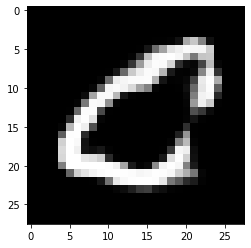

(94372, 28, 28, 1)
(94372,)


In [16]:
import numpy as np 
import matplotlib.pyplot as plt

# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z0/'
adv_files = []
X_adv = []
y_adv = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y_adv.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X_adv.extend(data[keys[0]])

X_adv = np.array(X_adv)
y_adv = np.array(y_adv)
y_one_hot = np.take(np.eye(10), y_adv, axis=0)

plt.imshow(X_adv[0], cmap='gray')
plt.show()
print(X_adv.shape)
print(y_adv.shape)

In [10]:
model.evaluate(X_adv, y_adv)

[2.5970321695068814, 0.16358666]

In [11]:
model.evaluate(x_test, y_test)

[0.21455569696724378, 0.9771]

## Tests on model_adv (trained on Unrestricted Adversarial Examples)

### Test model_adv against Unrestricted Adversarial Examples

In [22]:
# load model_adv
model_adv = tf.keras.models.load_model('assets/models/mnist_adv_model.h5')

In [17]:
model_adv.evaluate(X_adv, y_adv)

c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.002769992194468266, 0.9991947]

### Test model_adv against Clean Examples

In [16]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [26]:
model_adv.evaluate(ds_test)

[0.056600362118267265, 0.9858]

In [43]:
model_adv.evaluate(x_train, y_train)

1875/1875 [==============================] - 7s 4ms/step - loss: 879.6095 - sparse_categorical_accuracy: 0.7211


[879.6094970703125, 0.7210833430290222]

## Train Zico MNIST on Adversarial Examples

### Import libraries and load dataset

In [3]:
# Import the attack
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Generate SPSA for Zico MNIST

In [8]:
from cleverhans.tf2.attacks.spsa import spsa

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [9]:
# load mnist
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

In [16]:
# perform spsa on train_images
attack = spsa(logits_model, x = train_images, y = train_labels, eps = 0.3, nb_iter = 10)

# perform the attack
adv_images = attack.generate(train_images)


AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

### Generate FGSM for Zico MNIST

In [6]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [7]:
# load mnist
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

In [8]:

random_index = np.random.randint(test_images.shape[0])

original_image = test_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

In [14]:
# calculate error rate for FGSM attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 1.5, 0.1)
fgsm_images = []
fgsm_labels = []
model_adv_missclassifications = np.arange(0, len(epsilon_values))
model_missclassifications = np.arange(0, len(epsilon_values))


for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images.shape[0]):

        original_image = test_images[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels[i]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

        adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

        # adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
        # adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)
        
        # add fgsm image to list
        fgsm_images.append(adv_example_untargeted_label)
        fgsm_labels.append(original_label)

        # if np.argmax(adv_example_untargeted_label_pred) != original_label[0]:
        #     model_missclassifications[index] += 1
        # if np.argmax(adv_example_untargeted_label_pred_adv_model) != original_label[0]:
        #     model_adv_missclassifications[index] += 1
        
    
print(model_missclassifications)
print(model_adv_missclassifications)

np.savez('fgsm_images_zico', images=fgsm_images, labels=fgsm_labels)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


### Generate PGD for Zico MNIST

In [16]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [17]:
# calculate error rate for PGD attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 1.5, 0.1)
pgd_images = []
pgd_labels = []
model_adv_missclassifications = np.arange(0, len(epsilon_values))
model_missclassifications = np.arange(0, len(epsilon_values))

for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images.shape[0]):

        original_image = test_images[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)), dtype=tf.float32) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels[i]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

        adv_example_untargeted_label = projected_gradient_descent(model_fn=logits_model, x=original_image, eps=epsilon, eps_iter=0.01, targeted=False, nb_iter=200, norm=2)

        # adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
        # adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)
        
        # add pgd image to list
        pgd_images.append(adv_example_untargeted_label)
        pgd_labels.append(original_label)

        # if np.argmax(adv_example_untargeted_label_pred) != original_label[0]:
        #     model_missclassifications[index] += 1
        # if np.argmax(adv_example_untargeted_label_pred_adv_model) != original_label[0]:
        #     model_adv_missclassifications[index] += 1
        
    
print(model_missclassifications)
print(model_adv_missclassifications)

np.savez('pgd_images_zico', images=pgd_images, labels=pgd_labels)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


### Test model_adv on Zico MNIST based FGSM and PGD adversarial examples

In [4]:
# load fgsm and pgd images and labels
# import fgsm and pgd adversarial sampels
pgd_images_zico = np.load('pgd_images_zico.npz')['images']
pgd_labels_zico = np.load('pgd_images_zico.npz')['labels']

fgsm_images_zico = np.load('fgsm_images_zico.npz')['images']
fgsm_labels_zico = np.load('fgsm_images_zico.npz')['labels']

# reshape pgd and fgsm images to 28, 28, 1
pgd_images_zico = np.reshape(pgd_images_zico, (len(pgd_images_zico), 28, 28, 1))
fgsm_images_zico = np.reshape(fgsm_images_zico, (len(fgsm_images_zico), 28, 28, 1))

print(pgd_images_zico.shape)
print(pgd_labels_zico.shape)
print(fgsm_images_zico.shape)
print(fgsm_labels_zico.shape)

(140000, 28, 28, 1)
(140000, 1)
(140000, 28, 28, 1)
(140000, 1)


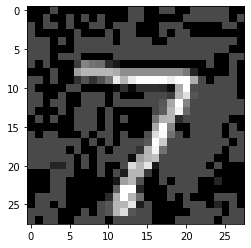

[[    0     1     2     3     4     5     6     7     8     9]
 [13720 15890 14448 14140 13748 12488 13412 14392 13636 14126]]


In [5]:
plt.imshow(fgsm_images_zico[10000], cmap='gray')
plt.show()

# show the first 1000 unique labels and counts
unique, counts = np.unique(fgsm_labels_zico, return_counts=True)
print(np.asarray((unique, counts)))

# take the first 1000 labels and images because higher epsilon values make the image unrecognizable
fgsm_images_zico = fgsm_images_zico[:1000]
fgsm_labels_zico = fgsm_labels_zico[:1000]

# squeeze fgsm_labels_zico and pgd_labels_zico to remove the extra dimension
fgsm_labels_zico = np.squeeze(fgsm_labels_zico)
pgd_labels_zico = np.squeeze(pgd_labels_zico)

In [25]:
model_adv.evaluate(pgd_images_zico, pgd_labels_zico)

4375/4375 [==============================] - 24s 5ms/step - loss: 0.0620 - sparse_categorical_accuracy: 0.9854


[0.061959680169820786, 0.9854142665863037]

In [18]:
model_adv.evaluate(fgsm_images_zico, fgsm_labels_zico)

32/32 [==============================] - 1s 21ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.9700


[0.15510913729667664, 0.9700000286102295]

#### Test PGD and FGSM on Clean Model

In [26]:
model.evaluate(pgd_images_zico, pgd_labels_zico)

4375/4375 [==============================] - 44s 10ms/step - loss: 2.2076 - accuracy: 0.2195


[2.2075695991516113, 0.21951428055763245]

In [27]:
model.evaluate(fgsm_images_zico, fgsm_labels_zico)

32/32 [==============================] - 1s 31ms/step - loss: 2.2860 - accuracy: 0.1530


[2.2860004901885986, 0.15299999713897705]

### Train Zico MNIST on Adversarial Examples

In [9]:
# divide pgd images to train and test
from sklearn.model_selection import train_test_split

pgd_images_zico_train, pgd_images_zico_test, pgd_labels_zico_train, pgd_labels_zico_test = train_test_split(pgd_images_zico, pgd_labels_zico, test_size=0.2, random_state=42)

In [12]:
# print shapes
print(pgd_images_zico_train.shape)
print(pgd_images_zico_test.shape)
print(pgd_labels_zico_train.shape)
print(pgd_labels_zico_test.shape)

(112000, 28, 28, 1)
(28000, 28, 28, 1)
(112000, 1)
(28000, 1)


In [28]:
# sequential model with conv2d 16, padding valid, relu -> conv2d 32, padding valid, relu -> softmax
model_madry = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=4, padding='valid', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, padding='valid', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [29]:
# train on mnist
model_madry.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model_madry.fit(
    x = pgd_images_zico_train,
    y = pgd_labels_zico_train,
    epochs=10
)
model_madry.evaluate(x_test, y_test)

Epoch 1/10
3500/3500 [==============================] - 95s 27ms/step - loss: 0.0457 - accuracy: 0.9862
Epoch 2/10
3500/3500 [==============================] - 72s 20ms/step - loss: 0.0043 - accuracy: 0.9985
Epoch 3/10
3500/3500 [==============================] - 27s 8ms/step - loss: 1.5566e-05 - accuracy: 1.0000
Epoch 4/10
3500/3500 [==============================] - 27s 8ms/step - loss: 1.9017e-06 - accuracy: 1.0000
Epoch 5/10
3500/3500 [==============================] - 27s 8ms/step - loss: 3.0125e-07 - accuracy: 1.0000
Epoch 6/10
3500/3500 [==============================] - 27s 8ms/step - loss: 4.8230e-08 - accuracy: 1.0000
Epoch 7/10
3500/3500 [==============================] - 27s 8ms/step - loss: 8.5767e-09 - accuracy: 1.0000
Epoch 8/10
3500/3500 [==============================] - 27s 8ms/step - loss: 1.5997e-09 - accuracy: 1.0000
Epoch 9/10
3500/3500 [==============================] - 28s 8ms/step - loss: 4.2575e-10 - accuracy: 1.0000
Epoch 10/10
313/313 [======================

[0.0, 1.0]

In [30]:
# save mnist_madry_zico_model
model_adv.save('assets/models/mnist_madry_zico_model.h5')

In [ ]:
# load mnist_madry_zico_model
model_adv = tf.keras.models.load_model('assets/models/mnist_madry_zico_model.h5')

In [31]:
model_madry.evaluate(fgsm_images_zico, fgsm_labels_zico)

32/32 [==============================] - 1s 18ms/step - loss: 1.8350e-06 - accuracy: 1.0000


[1.8349696802033577e-06, 1.0]

In [32]:
model_madry.evaluate(pgd_images_zico_test, pgd_labels_zico_test)

875/875 [==============================] - 15s 17ms/step - loss: 6.0456e-10 - accuracy: 1.0000


[6.045612899185926e-10, 1.0]

In [41]:
model_madry.evaluate(x_train, y_train)

1875/1875 [==============================] - 24s 13ms/step - loss: 101.2565 - accuracy: 0.9734


[101.25652313232422, 0.9734333157539368]

In [46]:
model_madry.evaluate(X_adv, y_adv)

2950/2950 [==============================] - 43s 14ms/step - loss: 0.6487 - accuracy: 0.9387


[0.6487031579017639, 0.9386576414108276]

### Test against TF Adversarial Regularization (Neural Structured Learning)

In [18]:
import neural_structured_learning as nsl

In [21]:
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)

In [22]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
adv_model.fit({'feature': x_train, 'label': y_train}, epochs=10)

In [77]:
adv_model.evaluate({'feature': x_test, 'label': y_test})

313/313 [==============================] - 23s 74ms/step - loss: 0.9171 - sparse_categorical_crossentropy: 0.7642 - sparse_categorical_accuracy: 0.9845 - scaled_adversarial_loss: 0.1528 17s - loss: 1.3784 - sparse_categorical_crossentropy: 1.1486 - sparse_cate - ETA: 12s - loss: 1.2796 - sparse_categorical_crossentropy: 1.0663 - sparse - ETA: 4s - loss: 0.9585 - sparse_categorical_crossentropy: 0.7988 - sparse_categorical_accuracy: 0.9829 - scal - ETA: 1s - loss: 0.8696 - sparse_categorical_crossentropy: 0.7246 - sparse_categorical_accuracy: 0.9847 - scaled_adversarial_los


[0.9170763492584229, 0.7642301321029663, 0.984499990940094, 0.1528460681438446]

In [78]:
adv_model.evaluate({'feature': X_adv, 'label': y_adv})

2950/2950 [==============================] - 160s 54ms/step - loss: 8.4431 - sparse_categorical_crossentropy: 6.9755 - sparse_categorical_accuracy: 0.2718 - scaled_adversarial_loss: 1.4676: 2:21 - loss: 11.4720 - sparse_categorical_crossentropy: 9.4846 - sparse_categorical_accuracy: 0.09 - ETA: 2:33 - loss: 9.8290 - sparse_categorical_crossentropy: 8.1198 - sparse_categorical_accuracy: 0.1380 - scaled_adversarial_loss: 1.70 - ETA: 2:32 - loss: 9.7401 - sparse_categorical_crossentropy: 8 - ETA: 2:15 - loss: 8.5072 - sparse_categorical_crossentropy: 7. - ETA: 2:12 - loss: 8 - ETA: 2:05 - loss: 5.0784 - sparse_categorical_crossentropy: 4.1903 - sparse_categorical_accuracy: 0.47 - ETA: 2:01 - loss: 4.5721 - sparse_categorical_crossentropy: 3.7725 - sparse_categorical_accuracy: 0.5313 - scaled_adversarial_loss: - ETA: 2:01 - loss: 4.4895 - sparse_categorical_crossentropy: 3.7043 - sparse_categor - ETA: 1:57 - loss: 4.8442 - sparse_categorical_crossentropy: 3.9990 - sparse_categorical_accura

[8.443138122558594, 6.975502014160156, 0.27180731296539307, 1.467640995979309]

In [79]:
adv_model.evaluate({'feature': pgd_images_zico_test, 'label': pgd_labels_zico_test})

875/875 [==============================] - 46s 52ms/step - loss: 5.6673 - sparse_categorical_crossentropy: 4.6687 - sparse_categorical_accuracy: 0.3579 - scaled_adversarial_loss: 0.9985 45s - loss: 5.6486 - sparse_categorical_crossentropy: 4.6521 - sparse_catego - ETA - ETA: 30s - loss: 5.7177 - sparse_categorical_crossentropy:  - ETA: 14s - loss: 5.7078 - sparse_categorical_crossentropy: 4.7023 - sparse_categorical_ac - ETA: 12s - loss: 5.7005  - ETA: 5s - loss: 5.6930 - sparse_categorical_crossentropy: 4.6899 - sparse_categorical_accuracy: 0.3542 - sca - ETA: 3s - loss: 5.6829 - sparse_categorical_crossentropy: 4.6816 - sparse_categorical_accuracy: 0.3557 -  - ETA: 0s - loss: 5.6677 - sparse_categorical_crossentropy: 4.6691 - sparse_categorical_accuracy: 0.3575 - scaled_adversarial_loss: 0


[5.667283535003662, 4.668737888336182, 0.35789287090301514, 0.9985463619232178]

In [80]:
adv_model.evaluate({'feature': fgsm_images_zico, 'label': fgsm_labels_zico})

32/32 [==============================] - 2s 48ms/step - loss: 5.4841 - sparse_categorical_crossentropy: 4.5147 - sparse_categorical_accuracy: 0.3620 - scaled_adversarial_loss: 0.9694


[5.4841108322143555, 4.514726638793945, 0.3619999885559082, 0.9693836569786072]

### ART Based Adversarial Classifier

#### Custom ART Adversarial Classifier

In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
(x_art_train, y_art_train), (x_art_test, y_art_test), min_, max_ = load_dataset('mnist')

In [15]:
tf.compat.v1.disable_eager_execution()

In [16]:
# load clean model
model = tf.keras.models.load_model('assets/models/mnist_zico.h5')
robust_classifier = KerasClassifier(model=model, use_logits=False)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 16)        272       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        8224      
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 10)                154890    
                                                                 
Total params: 163,386
Trainable params: 163,386
Non-trainable params: 0
_________________________________________________________________


In [20]:
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

In [26]:
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
trainer.fit(x_art_train, y_art_train, nb_epochs=10, batch_size=50)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
madry_art_zico = trainer.get_classifier()

In [ ]:
# test trainer on x_art_test
y_art_pred = madry_art_zico.predict(x_art_test)
y_art_pred = np.argmax(y_art_pred, axis=1)
y_art_test = np.argmax(y_art_test, axis=1)  

# print accuracy
print(np.sum(y_art_pred == y_art_test) / len(y_art_test))

#### Pretrained ART Classifier

In [6]:
tf.compat.v1.disable_eager_execution()

In [9]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

In [10]:
robust_classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)             

In [11]:
# Test against x_art_test
y_art_pred = robust_classifier.predict(x_art_test)
y_art_pred = np.argmax(y_art_pred, axis=1)
y_art_test = np.argmax(y_art_test, axis=1)

# print accuracy
print(np.sum(y_art_pred == y_art_test) / len(y_art_test))

0.9911


In [12]:
# Test against PGD
x_test_robust_pred = np.argmax(robust_classifier_model.predict(pgd_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == pgd_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == pgd_labels_zico) / len(pgd_labels_zico))

0.9910785714285715


In [14]:
# Test against FGSM
x_test_robust_pred = np.argmax(robust_classifier_model.predict(fgsm_images_zico), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == fgsm_labels_zico)

# print accuracy in percentage
print(np.sum(x_test_robust_pred == fgsm_labels_zico) / len(fgsm_labels_zico))

0.981


In [17]:
# Test against X_adv
x_test_robust_pred = np.argmax(robust_classifier_model.predict(X_adv), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_adv))

# print accuracy in percentage
print(np.sum(x_test_robust_pred == y_adv) / len(y_adv))

0.9494129614716229
